In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
DATASET_PATH = 'dataset'
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2

train_dataset = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=VALIDATION_SPLIT,
    subset="training",
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=VALIDATION_SPLIT,
    subset="validation",
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_dataset.class_names
print("Kelas yang ditemukan:", class_names)
num_classes = len(class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Found 15515 files belonging to 12 classes.
Using 12412 files for training.
Found 15515 files belonging to 12 classes.
Using 3103 files for validation.
Kelas yang ditemukan: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


In [3]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

In [4]:
IMG_SHAPE = IMAGE_SIZE + (3,)


base_model = MobileNetV2(input_shape=IMG_SHAPE,
                         include_top=False,
                         weights='imagenet')

base_model.trainable = False

model = Sequential([
    tf.keras.Input(shape=IMG_SHAPE),
    data_augmentation,
    tf.keras.layers.Lambda(tf.keras.applications.mobilenet_v2.preprocess_input),
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 12)               

In [5]:
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    verbose=1, 
    restore_best_weights=True
)

MODEL_PATH = 'models/garbage_classifier_v3_earlystop.h5'

model_checkpoint = ModelCheckpoint(
    MODEL_PATH, 
    monitor='val_loss', 
    save_best_only=True, 
    verbose=1
)

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=50,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/50
388/388 [==============================] - ETA: 0s - loss: 1.5734 - accuracy: 0.5198
Epoch 1: val_loss improved from inf to 0.87527, saving model to models\garbage_classifier_v3_earlystop.h5
388/388 [==============================] - 223s 548ms/step - loss: 1.5734 - accuracy: 0.5198 - val_loss: 0.8753 - val_accuracy: 0.7818
Epoch 2/50
388/388 [==============================] - ETA: 0s - loss: 0.7897 - accuracy: 0.7757
Epoch 2: val_loss improved from 0.87527 to 0.55961, saving model to models\garbage_classifier_v3_earlystop.h5
388/388 [==============================] - 212s 547ms/step - loss: 0.7897 - accuracy: 0.7757 - val_loss: 0.5596 - val_accuracy: 0.8601
Epoch 3/50
388/388 [==============================] - ETA: 0s - loss: 0.5883 - accuracy: 0.8322
Epoch 3: val_loss improved from 0.55961 to 0.44114, saving model to models\garbage_classifier_v3_earlystop.h5
388/388 [==============================] - 262s 676ms/step - loss: 0.5883 - accuracy: 0.8322 - val_loss: 0.4411 - va

### PLOT ACCURACY & LOSS

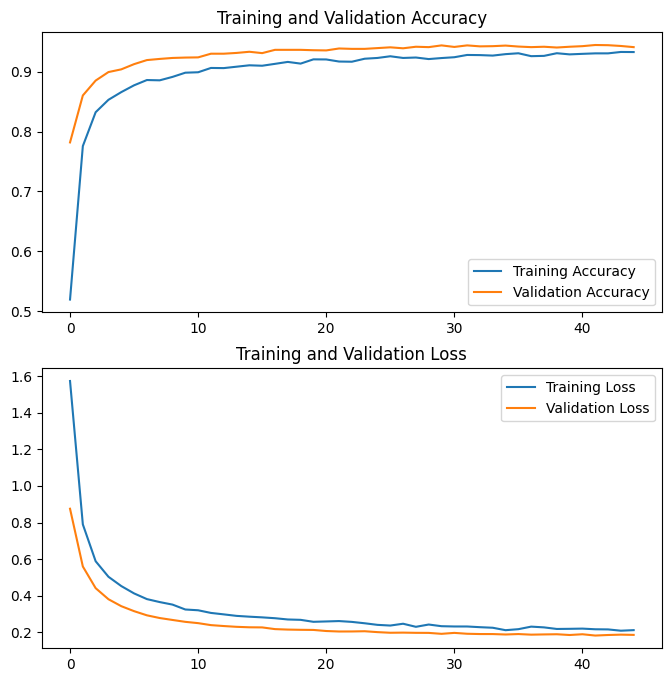

Model berhasil disimpan! models/garbage_classifier_v3_earlystop.h5

   HASIL EVALUASI AKHIR

Loss Akhir      : 0.1821
Akurasi Akhir   : 94.42%


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

model.save(MODEL_PATH)
print(f"Model berhasil disimpan! {MODEL_PATH}")
print()
print("HASIL EVALUASI AKHIR")
print()
print(f"Loss Akhir      : {results[0]:.4f}")
print(f"Akurasi Akhir   : {results[1] * 100:.2f}%")

import pickle
with open('models/class_names.pkl', 'wb') as f:
    pickle.dump(class_names, f)